<a href="https://colab.research.google.com/github/mr-alamdari/Video-Processing-Pytorch/blob/main/Video_Processing_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import copy
import torch
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torchsummary

#Dataset
[HMDB](https:/​/​serre-​lab.​clps.brown.​edu/​resource/​hmdb-​a-​large-​human-​motion-​database/​#overview): a large human motion database with 7000 clips in 51 action classes and 2 GB size

In [2]:
!wget https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar

--2022-04-08 04:16:24--  https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Resolving serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)... 128.148.254.114
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2124008126 (2.0G)
Saving to: ‘hmdb51_org.rar’

hmdb51_org.rar      100%[===================>]   1.98G  71.2MB/s    in 31s     

2022-04-08 04:16:55 (65.7 MB/s) - ‘hmdb51_org.rar’ saved [2124008126/2124008126]



In [3]:
!pip install patool
import patoolib
os.makedirs('/content/data', exist_ok=True)
os.makedirs('/content/data/hmdb51_org/', exist_ok=True)
patoolib.extract_archive("hmdb51_org.rar", outdir="/content/data/hmdb51_org/")

     |████████████████████████████████| 77 kB 2.9 MB/s 
patool: Extracting hmdb51_org.rar ...
patool: running /usr/bin/unrar x -- /content/hmdb51_org.rar
patool:     with cwd='/content/data/hmdb51_org/'
patool: ... hmdb51_org.rar extracted to `/content/data/hmdb51_org/'.


'/content/data/hmdb51_org/'

In [4]:
sub_folder = "hmdb51_org"
sub_folder_jpg = "hmdb51_jpg"
rar_names = os.listdir('/content/data/hmdb51_org')
os.remove("/content/hmdb51_org.rar")
for dir in rar_names:
  patoolib.extract_archive(f"/content/data/hmdb51_org/{dir}", outdir="/content/data/hmdb51_org/")
  os.remove(f"/content/data/hmdb51_org/{dir}")

patool: Extracting /content/data/hmdb51_org/talk.rar ...
patool: running /usr/bin/unrar x -- /content/data/hmdb51_org/talk.rar
patool:     with cwd='/content/data/hmdb51_org/'
patool: ... /content/data/hmdb51_org/talk.rar extracted to `/content/data/hmdb51_org/'.
patool: Extracting /content/data/hmdb51_org/push.rar ...
patool: running /usr/bin/unrar x -- /content/data/hmdb51_org/push.rar
patool:     with cwd='/content/data/hmdb51_org/'
patool: ... /content/data/hmdb51_org/push.rar extracted to `/content/data/hmdb51_org/'.
patool: Extracting /content/data/hmdb51_org/shoot_ball.rar ...
patool: running /usr/bin/unrar x -- /content/data/hmdb51_org/shoot_ball.rar
patool:     with cwd='/content/data/hmdb51_org/'
patool: ... /content/data/hmdb51_org/shoot_ball.rar extracted to `/content/data/hmdb51_org/'.
patool: Extracting /content/data/hmdb51_org/smile.rar ...
patool: running /usr/bin/unrar x -- /content/data/hmdb51_org/smile.rar
patool:     with cwd='/content/data/hmdb51_org/'
patool: ... 

In [5]:
path2data = '/content/data/'
path2cat = '/content/data/hmdb51_org'
categories = os.listdir(path2cat)
print(len(categories))
categories

51


['shake_hands',
 'push',
 'golf',
 'pour',
 'turn',
 'pullup',
 'handstand',
 'laugh',
 'ride_bike',
 'sit',
 'run',
 'cartwheel',
 'somersault',
 'shoot_bow',
 'eat',
 'drink',
 'pushup',
 'draw_sword',
 'shoot_ball',
 'hug',
 'climb',
 'swing_baseball',
 'kiss',
 'hit',
 'kick',
 'sword',
 'catch',
 'talk',
 'fencing',
 'wave',
 'punch',
 'dive',
 'dribble',
 'clap',
 'kick_ball',
 'stand',
 'pick',
 'smoke',
 'flic_flac',
 'shoot_gun',
 'smile',
 'brush_hair',
 'climb_stairs',
 'chew',
 'ride_horse',
 'walk',
 'throw',
 'sword_exercise',
 'jump',
 'situp',
 'fall_floor']

In [6]:
for cat in categories:
  videos = os.listdir(f'{path2cat}/{cat}')
  print(cat, len(videos))

shake_hands 162
push 116
golf 105
pour 106
turn 240
pullup 104
handstand 113
laugh 128
ride_bike 103
sit 142
run 232
cartwheel 107
somersault 140
shoot_bow 112
eat 108
drink 164
pushup 103
draw_sword 103
shoot_ball 131
hug 118
climb 108
swing_baseball 143
kiss 102
hit 127
kick 130
sword 127
catch 102
talk 120
fencing 116
wave 104
punch 126
dive 127
dribble 145
clap 130
kick_ball 128
stand 154
pick 106
smoke 109
flic_flac 107
shoot_gun 103
smile 102
brush_hair 107
climb_stairs 112
chew 109
ride_horse 116
walk 548
throw 102
sword_exercise 127
jump 151
situp 105
fall_floor 136


In [7]:
# !https://github.com/PacktPublishing/PyTorch-Computer-Vision-Cookbook/blob/master/Chapter10/myutils.py
from tqdm import tqdm_notebook
import matplotlib.pylab as plb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_vids(path2ajpgs):
    listOfCats = os.listdir(path2ajpgs)
    ids = []
    labels = []
    for catg in listOfCats:
        path2catg = os.path.join(path2ajpgs, catg)
        listOfSubCats = os.listdir(path2catg)
        path2subCats= [os.path.join(path2catg,los) for los in listOfSubCats]
        ids.extend(path2subCats)
        labels.extend([catg]*len(listOfSubCats))
    return ids, labels, listOfCats 

def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = torchvision.transforms.functional.to_pil_image(x)        
    return x

def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": [],
    }
    
    metric_history={
        "train": [],
        "val": [],
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
        

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output,target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b
    

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data = len(dataset_dl.dataset)
    for xb, yb in tqdm_notebook(dataset_dl):
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb)
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss+=loss_b
        
        if metric_b is not None:
            running_metric+=metric_b
        if sanity_check is True:
            break
    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data)
    return loss, metric


def plot_loss(loss_hist, metric_hist):

    num_epochs= len(loss_hist["train"])

    plb.title("Train-Val Loss")
    plb.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
    plb.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
    plb.ylabel("Loss")
    plb.xlabel("Training Epochs")
    plb.legend()
    plb.show()

    plb.title("Train-Val Accuracy")
    plt.plot(range(1,num_epochs+1), metric_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1), metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()
    
class Resnt18Rnn(torch.nn.Module):
    def __init__(self, params_model):
        super(Resnt18Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        
        baseModel = models.resnet18(pretrained=pretrained)
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout= torch.nn.Dropout(dr_rate)
        self.rnn = torch.nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = torch.nn.Linear(rnn_hidden_size, num_classes)
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0
        y = self.baseModel((x[:,ii]))
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        for ii in range(1, ts):
            y = self.baseModel((x[:,ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        out = self.dropout(out[:,-1])
        out = self.fc1(out) 
        return out 
    
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x    


from torchvision import models
from torch import nn

def get_model(num_classes, model_type="rnn"):
    if model_type == "rnn":
        params_model={
            "num_classes": num_classes,
            "dr_rate": 0.1,
            "pretrained" : True,
            "rnn_num_layers": 1,
            "rnn_hidden_size": 100,}
        model = Resnt18Rnn(params_model)        
    else:
        model = models.video.r3d_18(pretrained=True, progress=False)
        num_features = model.fc.in_features
        model.fc = torch.nn.Linear(num_features, num_classes)    
    return model


import cv2
import numpy as np
def get_frames(filename, n_frames= 1):
    frames = []
    v_cap = cv2.VideoCapture(filename)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_list= np.linspace(0, v_len-1, n_frames+1, dtype=np.int16)
    
    for fn in range(v_len):
        success, frame = v_cap.read()
        if success is False:
            continue
        if (fn in frame_list):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
            frames.append(frame)
    v_cap.release()
    return frames, v_len


import torchvision.transforms as transforms
from PIL import Image
def transform_frames(frames, model_type="rnn"):
    if model_type == "rnn":
        h, w = 224, 224
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        h, w = 112, 112
        mean = [0.43216, 0.394666, 0.37645]
        std = [0.22803, 0.22145, 0.216989]

    test_transformer = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)]) 

    frames_tr = []
    for frame in frames:
        frame = Image.fromarray(frame)
        frame_tr = test_transformer(frame)
        frames_tr.append(frame_tr)
    imgs_tensor = torch.stack(frames_tr)    

    if model_type=="3dcnn":
        imgs_tensor = torch.transpose(imgs_tensor, 1, 0)
    imgs_tensor = imgs_tensor.unsqueeze(0)
    return imgs_tensor


def store_frames(frames, path2store):
    for ii, frame in enumerate(frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  
        path2img = os.path.join(path2store, "frame"+str(ii)+".jpg")
        cv2.imwrite(path2img, frame)


In [8]:
extension = '.avi'
n_frames = 16
for root, dirs, files in os.walk(path2cat, topdown=False):
  for name in files:
    if extension not in name:
      continue
    path2vid = os.path.join(root, name)
    frames, vlen = get_frames(path2vid, n_frames=n_frames)
    path2store = path2vid.replace(sub_folder, sub_folder_jpg)
    path2store = path2store.replace(extension, '')
    print(path2store)
    os.makedirs(path2store, exist_ok=True)
    store_frames(frames, path2store)

Streaming output truncated to the last 5000 lines.
/content/data/hmdb51_jpg/somersault/Pirates_2_somersault_f_cm_np1_fr_bad_5
/content/data/hmdb51_jpg/somersault/Philli_beim_Bodenturnen_somersault_f_cm_np1_ri_bad_5
/content/data/hmdb51_jpg/somersault/meine_Bodenk_r_somersault_f_cm_np1_ri_bad_1
/content/data/hmdb51_jpg/somersault/MWG_Bodenturnen_somersault_f_cm_np2_ri_bad_0
/content/data/hmdb51_jpg/somersault/Jennis_Bodenk_r_somersault_f_cm_np1_le_med_1
/content/data/hmdb51_jpg/somersault/meine_Bodenk_r_somersault_f_cm_np1_le_bad_2
/content/data/hmdb51_jpg/somersault/Turnen_Lisa_en_Janine_op_de_Balk_somersault_f_cm_np1_ri_bad_1
/content/data/hmdb51_jpg/somersault/Liri_beim_Bodenturnen_somersault_f_cm_np1_le_bad_0
/content/data/hmdb51_jpg/somersault/hechtsprung_3_somersault_f_cm_np1_le_bad_0
/content/data/hmdb51_jpg/somersault/Le_Parkour_et_Accros_Kevin_Ryser_2008-2009_somersault_f_nm_np1_le_med_0
/content/data/hmdb51_jpg/somersault/Handstandk_nig_somersault_f_cm_np1_ba_med_5
/content/da

In [9]:
path2data = '/content/data/'
path2ajpgs = os.path.join(path2data, sub_folder_jpg)
all_vids, all_labels, catgs = get_vids(path2ajpgs)
len(all_vids), len(all_labels), len(catgs)

(6766, 6766, 51)

In [10]:
all_vids[:3], all_labels[:3], catgs[:3]

(['/content/data/hmdb51_jpg/shake_hands/Jay_Leno_@_David_Letterman_shake_hands_f_cm_np2_le_med_0',
  '/content/data/hmdb51_jpg/shake_hands/Emma_2008_Eurofinals_-_prize_giving_ceremony_Team_Pioneer_members_divx_shake_hands_u_cm_np2_le_med_6',
  '/content/data/hmdb51_jpg/shake_hands/IPL_Awards_Ceremony_shake_hands_u_cm_np2_ba_med_7'],
 ['shake_hands', 'shake_hands', 'shake_hands'],
 ['shake_hands', 'push', 'golf'])

In [11]:
labels_dict = {}
ind = 0
for u in catgs:
  labels_dict[u] = ind
  ind += 1

labels_dict

{'brush_hair': 41,
 'cartwheel': 11,
 'catch': 26,
 'chew': 43,
 'clap': 33,
 'climb': 20,
 'climb_stairs': 42,
 'dive': 31,
 'draw_sword': 17,
 'dribble': 32,
 'drink': 15,
 'eat': 14,
 'fall_floor': 50,
 'fencing': 28,
 'flic_flac': 38,
 'golf': 2,
 'handstand': 6,
 'hit': 23,
 'hug': 19,
 'jump': 48,
 'kick': 24,
 'kick_ball': 34,
 'kiss': 22,
 'laugh': 7,
 'pick': 36,
 'pour': 3,
 'pullup': 5,
 'punch': 30,
 'push': 1,
 'pushup': 16,
 'ride_bike': 8,
 'ride_horse': 44,
 'run': 10,
 'shake_hands': 0,
 'shoot_ball': 18,
 'shoot_bow': 13,
 'shoot_gun': 39,
 'sit': 9,
 'situp': 49,
 'smile': 40,
 'smoke': 37,
 'somersault': 12,
 'stand': 35,
 'swing_baseball': 21,
 'sword': 25,
 'sword_exercise': 47,
 'talk': 27,
 'throw': 46,
 'turn': 4,
 'walk': 45,
 'wave': 29}

In [12]:
num_classes = 5

unique_ids, unique_labels = [], []
for id, label in zip(all_vids, all_labels):
  if labels_dict[label] < num_classes:
    unique_ids.append(id) 
    unique_labels.append(label)  

In [13]:
len(unique_ids), len(unique_labels)

(729, 729)

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=24)
train_indx, test_indx = next(sss.split(unique_ids, unique_labels))

train_ids = [unique_ids[ind] for ind in train_indx]
train_labels = [unique_labels[ind] for ind in train_indx]

print(len(train_ids), len(train_labels))

test_ids = [unique_ids[ind] for ind in test_indx]
test_labels = [unique_labels[ind] for ind in test_indx]

print(len(test_ids), len(test_labels))

656 656
73 73


In [23]:
import glob
timesteps = 16

np.random.seed(23)
torch.manual_seed(23)

class VideoDataset(torch.utils.data.Dataset):
  def __init__(self, ids, labels, transform):
    self.ids = ids
    self.labels = labels
    self.transform = transform
  
  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, idx):
    path2imgs = glob.glob(self.ids[idx]+'/*.jpg')
    path2imgs = path2imgs[:timesteps]
    label = labels_dict[self.labels[idx]]
    frames = []
    for p2i in path2imgs:
      frame = PIL.Image.open(p2i)
      frames.append(frame)
    
    seed = np.random.randint(1e9)
    frames_tr = []
    for frame in frames:
      np.random.seed(seed)
      frame = self.transform(frame)
      frames_tr.append(frame)
    if len(frames_tr) > 0:
      frames_tr = torch.stack(frames_tr)
    return frames_tr, label

In [24]:
flag = True
model_type = '3dcnn' if flag else 'rnn'

if model_type == 'rnn':
  h, w = 224, 224
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
else:
  h, w = 112, 112
  mean = [0.43216, 0.394666, 0.37645]
  std = [0.22803, 0.22145, 0.216989]

In [34]:
train_transforms = torchvision.transforms.Compose([
                   torchvision.transforms.Resize((h, w)),
                   torchvision.transforms.RandomHorizontalFlip(p=0.5),
                   torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                   torchvision.transforms.ToTensor(),
                   torchvision.transforms.Normalize(mean, std)
])

test_transforms = torchvision.transforms.Compose([
                  torchvision.transforms.Resize((h, w)),
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize(mean, std)
])

In [35]:
train_ds = VideoDataset(ids=train_ids, labels=train_labels, transform=train_transforms)

test_ds = VideoDataset(ids=test_ids, labels=test_labels, transform=test_transforms)


In [27]:
img, label = train_ds[34]
img.shape, label, torch.min(img), torch.max(img)

(torch.Size([16, 3, 112, 112]), 1, tensor(-1.8952), tensor(2.8736))

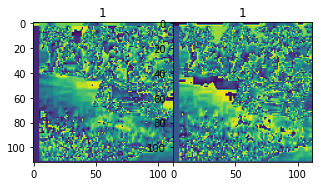

In [30]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(wspace=0, hspace=0)
for i, im in enumerate(img[::2]):
  plt.subplot(1, 8, i+1)
  plt.imshow(denormalize(im, mean, std))
  plt.title(label)

In [36]:
img, label = test_ds[34]
img.shape, label, torch.min(img), torch.max(img)

(torch.Size([16, 3, 112, 112]), 0, tensor(-1.8952), tensor(2.8736))

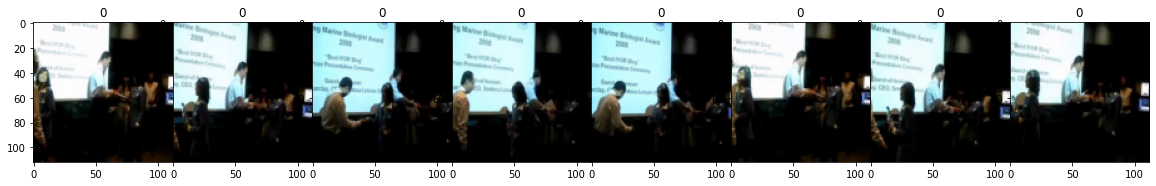

In [37]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(wspace=0, hspace=0)
for i, im in enumerate(img[::2]):
  plt.subplot(1, 8, i+1)
  plt.imshow(denormalize(im, mean, std))
  plt.title(label)

In [39]:
def collate_fn_r3d_18(batch):
  imgs_batch, label_batch = list(zip(*batch))
  imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
  label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
  imgs_tensor = torch.stack(imgs_batch)
  imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
  labels_tensor = torch.stack(label_batch)
  return imgs_tensor, labels_tensor

In [40]:
def collate_fn_rnn(batch):
  imgs_batch, label_batch = list(zip(*batch))
  imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
  label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
  imgs_tensor = torch.stack(imgs_batch)
  labels_tensor = torch.stack(label_batch)
  return imgs_tensor, labels_tensor

In [45]:
batch_size=1
collate_fn = collate_fn_rnn if model_type == 'rnn' else collate_fn_r3d_18

train_dl = torch.utils.data.DataLoader(train_ds,batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=2*batch_size, shuffle=False, collate_fn=collate_fn)

In [44]:
for (x, y), (z, p) in zip(train_dl, test_dl):
  print(x.shape, y.shape)
  print(z.shape, p.shape)
  break

torch.Size([1, 3, 16, 112, 112]) torch.Size([1])
torch.Size([2, 3, 16, 112, 112]) torch.Size([2])


#Model

In [46]:
class Resnet18Rnn(torch.nn.Module):
  def __init__(self, params_model):
    super(Resnet18Rnn, self).__init__()
    num_classes = params_model['num_classes']
    dr_rate = params_model['dr_rate']
    pretrained = params_model['pretrained']
    rnn_hidden_size = params_model['rnn_hidden_size']
    rnn_num_layers = params_model['rnn_num_layers']

    baseModel = models.resnet18(pretrained=pretrained)
    num_features = baseModel.fc.in_features
    baseModel.fc = Identity()
    self.baseModel = baseModel
    self.dropout = torch.nn.Dropout(dr_rate)
    self.rnn = torch.nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
    self.fc1 = torch.nn.Linear(rnn_hidden_size, num_classes)
  
  def forward(self, x):
    b, ts, c, g, w = x.shape

    for i in range(ts):
      y = self.baseModel(x[:, i])
      if i == 0:
        out, (hn, cn) = self.rnn(y.unzsqueeze(1))
      else:
        out, (hn, cn) = self.rnn(y.unzsqueeze(1), (hn, cn))

    out = self.dropout(out[:, -1])
    out = self.fc1(out)
    return out
  
class Identity(torch.nn.Module):
  def __init__(self):
    super(Identity, self).__init__()
  
  def forward(self, x):
    return x